In [143]:
# Installing the "datasets" library
!pip install -q datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [144]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification,  DataCollatorWithPadding
from transformers import InputExample, InputFeatures
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import pandas as pd
import tensorflow as tf

In [145]:
dataset = pd.read_csv("/kaggle/input/movies/movie_data.csv")
dataset = dataset.rename(columns={'review': 'text', 'sentiment': 'label'})
dataset.head()

,text,label
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [146]:
df_full_train, df_test = train_test_split(dataset, test_size=0.2, random_state=56)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=56)

In [147]:
df_train.shape, df_test.shape, df_val.shape

((30000, 2), (10000, 2), (10000, 2))

Let's explore this dataset: 

In [148]:
df_train = df_train.reset_index(drop=True)
df_val = df_train.reset_index(drop=True)
df_test = df_train.reset_index(drop=True)

train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

In [149]:
imdb_dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

In [150]:
imdb_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 30000
    })
})

Let's take a look at the first example from the "test" split of the dataset.

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>2. Data Preprocessing</div></b>

Let's initialize for the `distilbert-base-uncased` model. 

In [151]:
# Initializing the tokenizer for the "distilbert-base-uncased" model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

For example, let's tokenize the text of the first training example in the dataset using this tokenizer.

Let's define a preprocessing function named preprocess_function. This function takes a dictionary of examples as input and tokenizes the "text" field with truncation. 

In [152]:
# Preprocessing function for tokenization
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

After that let's use the map function to apply this preprocessing function to the entire dataset in batches.

In [153]:
# Applying the preprocessing function to the entire dataset in batches
imdb_dataset_dict = imdb_dataset_dict.map(preprocess_function, batched=True)

  0%|          | 0/30 [00:00<?, ?ba/s]

  0%|          | 0/30 [00:00<?, ?ba/s]

  0%|          | 0/30 [00:00<?, ?ba/s]

In [154]:
imdb_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 30000
    })
})

Let's create a batch of examples from the dataset.

In [155]:
# Initializing the data collator with padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>3. Model Loading</div></b>

Let's load the `distilbert` model for our sentiment analysis.

In [156]:
# Initializing a model for sequence classification using "distilbert-base-uncased"
my_model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Let's prepare training and validation datasets as TensorFlow datasets. 

In [157]:
# Preparing the training dataset as a TensorFlow dataset
tf_train_set = my_model.prepare_tf_dataset(
    imdb_dataset_dict["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

# Preparing the validation dataset as a TensorFlow dataset
tf_validation_set = my_model.prepare_tf_dataset(
    imdb_dataset_dict["validation"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

# Preparing the test dataset as a TensorFlow dataset
tf_test_set = my_model.prepare_tf_dataset(
    imdb_dataset_dict["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>4. Model Training</div></b>

Let's compile the model using the Adam optimizer with a learning rate of 3e-5.

Let's train the model using the prepared training and validation datasets for 2 epochs.

In [158]:
# Training the model
# my_model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=2)
my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

history = my_model.fit(tf_train_set, epochs=3, validation_data=tf_validation_set)

Epoch 1/3
1875/1875 [==============================] - 1359s 711ms/step - loss: 0.2453 - accuracy: 0.8995 - val_loss: 0.1030 - val_accuracy: 0.9653
Epoch 2/3
1875/1875 [==============================] - 1308s 698ms/step - loss: 0.1270 - accuracy: 0.9549 - val_loss: 0.0479 - val_accuracy: 0.9867
Epoch 3/3
1875/1875 [==============================] - 1307s 697ms/step - loss: 0.0606 - accuracy: 0.9808 - val_loss: 0.0185 - val_accuracy: 0.9956


# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>5. Prediction</div></b>

Let's get a sample text for inference.

In [159]:
import numpy as np
from tensorflow import math
import matplotlib.pyplot as plt

predictions = my_model.predict(tf_test_set).logits

1875/1875 [==============================] - 322s 171ms/step


In [160]:
softmax_predictions = tf.nn.softmax(predictions, axis=1)
predicted_classes = np.argmax(softmax_predictions, axis=1)


true_classes = test_dataset['label']
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Display confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Evaluate and print classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes))

Confusion Matrix:
[[14977    91]
 [   42 14890]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     15068
           1       0.99      1.00      1.00     14932

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



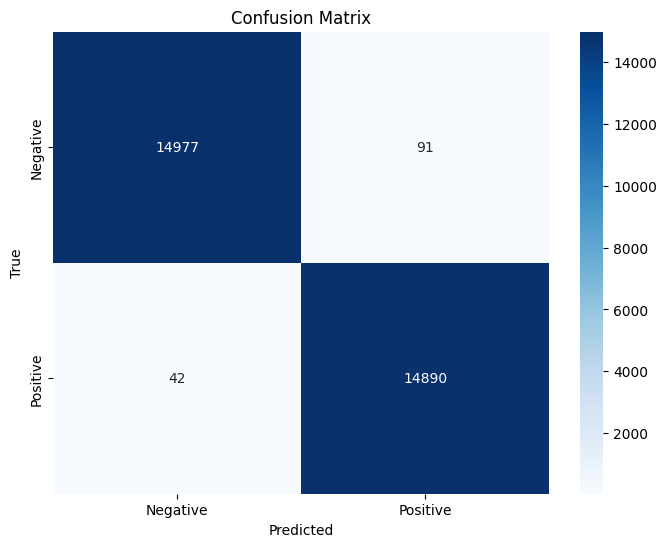

In [161]:
import seaborn as sns
# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [162]:
# Defining a text for inference
text = "I love NLP. It's fun to analyze the NLP tasks with Hugging Face."

Let's preprocess our text for passing our model.

In [163]:
# Tokenizing the text for inference
tokenized_text = tokenizer(text, return_tensors="tf")
tokenized_text 

{'input_ids': <tf.Tensor: shape=(1, 21), dtype=int32, numpy=
array([[  101,  1045,  2293, 17953,  2361,  1012,  2009,  1005,  1055,
         4569,  2000, 17908,  1996, 17953,  2361,  8518,  2007, 17662,
         2227,  1012,   102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 21), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
      dtype=int32)>}

Next, let's compute the model's logits (raw output scores) for the tokenized text.

In [164]:
# Obtaining model logits for the tokenized text
logits = my_model(**tokenized_text).logits

In [165]:
logits

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-1.775552 ,  1.7464507]], dtype=float32)>

Lastly, let's print the index of the class with the highest logit score.

In [166]:
# Finding the index of the class with the highest logit score
int(math.argmax(logits, axis=-1)[0])

1

Thanks for reading. If you enjoyed this notebook, don't forget to upvote ☺️

Let's connect [YouTube](http://youtube.com/tirendazacademy) | [Medium](http://tirendazacademy.medium.com) | [Twitter](http://twitter.com/tirendazacademy) | [Linkedin](https://www.linkedin.com/in/tirendaz-academy) 😎